# Table of Contents
 <p><div class="lev1"><a href="#helper-1">helper</a></div><div class="lev1"><a href="#lmfit-lorentzian-amplitude-2">lmfit lorentzian amplitude</a></div><div class="lev2"><a href="#function-to-fit-using-lmfit-2.1">function to fit using lmfit</a></div><div class="lev2"><a href="#bob-2.2">bob</a></div><div class="lev1"><a href="#loop-over-all-cases-3">loop over all cases</a></div><div class="lev1"><a href="#vary-fitting-window-4">vary fitting window</a></div><div class="lev1"><a href="#sumit-5">sumit</a></div>

In [1]:
# env source /Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [2]:
import sys
sys.path.append("../../nonspin/")

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [140]:
matplotlib.rcParams.update({'font.size': 22})

# helper

In [141]:

def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


In [142]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.3f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)

        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        

# lmfit lorentzian amplitude

In [143]:
# get data
nrfiles = dict(
    q1='/Users/sebastian/Desktop/work/data/SXS_BBH_0071_Res5.h5',
    q2='/Users/sebastian/Desktop/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/sebastian/Desktop/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/sebastian/Desktop/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/sebastian/Desktop/work/data/SXS_BBH_0303_Res5.h5'
)

In [144]:
nrfiles['q1']

'/Users/sebastian/Desktop/work/data/SXS_BBH_0071_Res5.h5'

In [145]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
# t1=-600
t1=-800
t2=80


In [146]:
psi4s = {}
for k,v in nrfiles.iteritems():
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

In [147]:
for k in psi4s.keys():
    print(1./psi4s[k].fdamp/2/np.pi)

11.706422641558191
11.554740530290251
11.32930696199893
11.272552160962043
11.36516841490208


Text(0.5,1,'$|\\Psi_4|(t)$')

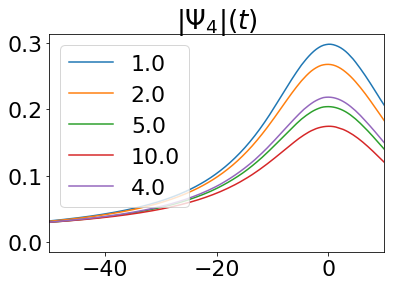

In [148]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
plt.legend()
plt.xlim(-50,10)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

In [149]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$')

Text(0.5,1,'$\\omega_{gw}(t)$')

## function to fit using lmfit

In [356]:
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_amp_ramp_up(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
        
        return model
    
    def model_amp_ramp_up_to_min(self, params, t, data):
        model = self.model_amp_ramp_up(params, t)
        return model - data
        
    def fit_amp_ramp_up(self, fix_tdamp, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_amp_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_amp[self.model_amp_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-100, max=200)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=2000)
        params.add('a1', value=0., min=-2000, max=2000)
        
        fcn2min = self.model_amp_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.amp_ramp_up_result = minner.minimize()

        # calculate final result
        self.amp_ramp_up_final = self.fit_data + self.amp_ramp_up_result.residual

        # write error report
        report_fit(self.amp_ramp_up_result)
        
        
        
    def model_amp_bob(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        ap = params['ap']
        
        sech = 1/np.cosh( (tp - t) / tdamp )
        model = ap * sech

        return model
    
    def model_amp_bob_to_min(self, params, t, data):
        model = self.model_amp_bob(params, t)
        return model - data
        
    def fit_amp_bob(self, fix_tdamp, t1=-20, t2=20):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_bob_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_bob = self.Psi4.times[self.model_amp_bob_mask]
        self.fit_data_bob = self.Psi4.psi4lm_amp[self.model_amp_bob_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=0, min=-100, max=200)
        params.add('ap', value=0., min=-2000, max=2000)
        
        fcn2min = self.model_amp_bob_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_bob, self.fit_data_bob))
        
        self.amp_bob_result = minner.minimize()

        # calculate final result
        self.amp_bob_final = self.fit_data_bob + self.amp_bob_result.residual

        # write error report
        report_fit(self.amp_bob_result)
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def amp_model(self, times, t0 = -10, sigma=0.1):
        
        self.ramp_up = self.model_amp_ramp_up(self.amp_ramp_up_result.params, times)
        self.bob = self.model_amp_bob(self.amp_bob_result.params,times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.bob
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_amp
        self.y_model = self.amp_model(self.t_data, t0=t0, sigma=sigma)

In [357]:
q1_fit = Model(psi4s['q1'])
q1_fit.fit_amp_ramp_up(fix_tdamp=False, t1=-800, t2=-10)
q1_fit.fit_amp_bob(fix_tdamp=False, t1=-10, t2=20)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 1795
    # variables        = 5
    chi-square         = 2.5090e-06
    reduced chi-square = 1.4017e-09
    Akaike info crit   = -36587.1686
    Bayesian info crit = -36559.7048
[[Variables]]
    tdamp:    29.2076684 +/- 4.26493564 (14.60%) (init = 20)
    tp:       24.3105663 +/- 2.37884949 (9.79%) (init = 20)
    lor_amp: -3.59402792 +/- 1.97355815 (54.91%) (init = 0)
    a0:      -0.37184941 +/- 0.00113228 (0.30%) (init = 0)
    a1:       107.591099 +/- 42.8843528 (39.86%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1)    = -1.000
    C(tp, a1)         =  1.000
    C(tp, lor_amp)    = -1.000
    C(tdamp, lor_amp) =  1.000
    C(tdamp, a1)      = -1.000
    C(tdamp, tp)      = -0.999
    C(tp, a0)         = -0.808
    C(a0, a1)         = -0.804
    C(lor_amp, a0)    =  0.802
    C(tdamp, a0)      =  0.794
[[Fit Statistics]]
    # fitting meth

In [358]:
q1_fit_fix_tdamp = Model(psi4s['q1'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 125
    # data points      = 1795
    # variables        = 4
    chi-square         = 2.9293e-06
    reduced chi-square = 1.6356e-09
    Akaike info crit   = -36311.1591
    Bayesian info crit = -36289.1880
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       32.0242728 +/- 0.07856440 (0.25%) (init = 20)
    lor_amp: -82.6365107 +/- 0.73411186 (0.89%) (init = 0)
    a0:      -0.37653907 +/- 7.8733e-04 (0.21%) (init = 0)
    a1:       971.253768 +/- 8.47419077 (0.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.993
    C(lor_amp, a0) =  0.752
    C(a0, a1)      = -0.748
    C(tp, a0)      = -0.696
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 68
    # variables        = 2
    chi-square         = 1.0092e-04
    reduced chi-square = 1.5291e-06
    

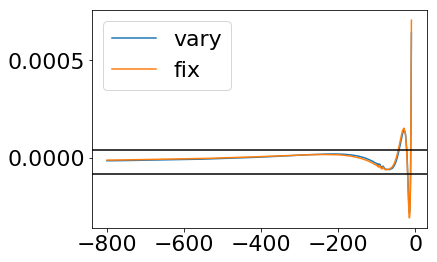

In [359]:

plt.figure()
# plt.plot(q1_fit.fit_times, q1_fit.fit_data)
plt.plot(q1_fit.fit_times, q1_fit.amp_ramp_up_result.residual, label='vary')
plt.plot(q1_fit_fix_tdamp.fit_times, q1_fit_fix_tdamp.amp_ramp_up_result.residual, label='fix')
plt.legend()
plt.axhline(4e-5, c='k')
plt.axhline(-8e-5, c='k')

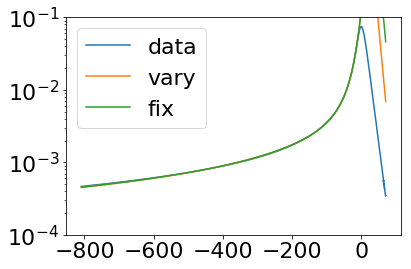

In [360]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


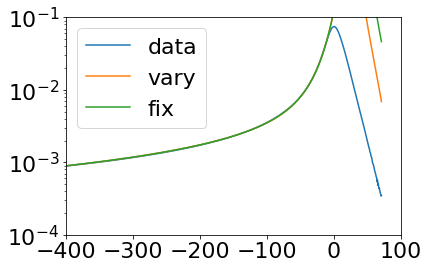

In [361]:
plt.figure()
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.legend()
# plt.xlim(-600,100)
plt.xlim(-400,100)
plt.ylim(0.0001,0.1)
plt.yscale('log')


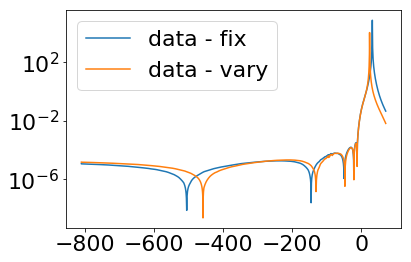

In [362]:
# residuals in extrapolation

ttt = q1_fit.Psi4.times
dddata = q1_fit.Psi4.psi4lm_amp
dddvary = q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times)
dddfix = q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times)

plt.figure()
plt.plot(ttt, np.abs(dddata - dddfix), label='data - fix')
plt.plot(ttt, np.abs(dddata - dddvary), label='data - vary')
plt.legend()
# plt.xlim(-600,100)
# plt.ylim(0.0001,0.1)
plt.yscale('log')


## bob

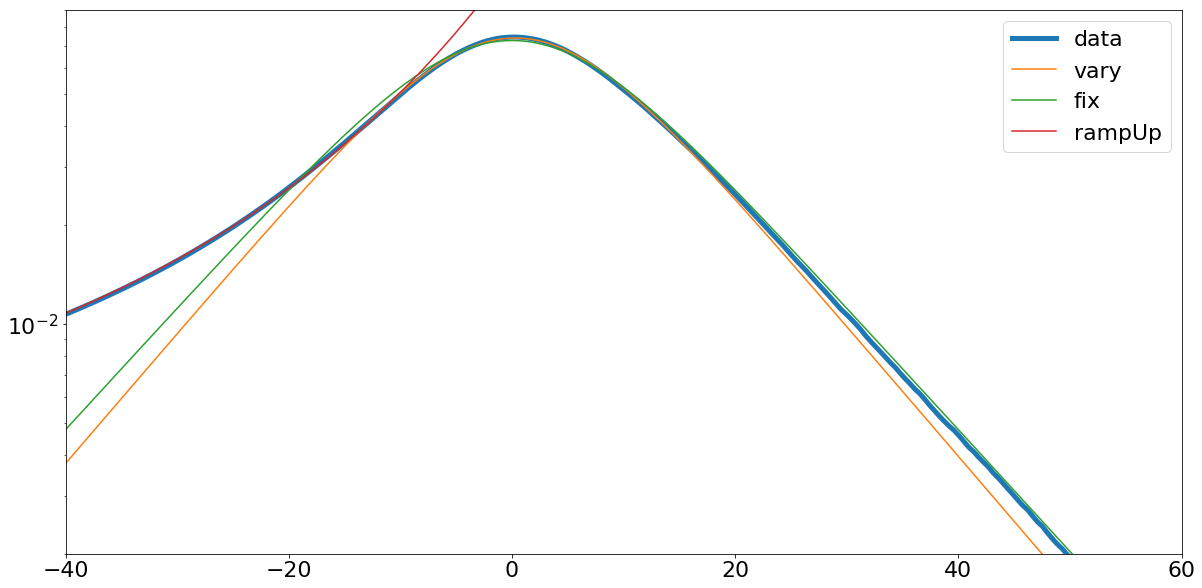

In [363]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data', lw=5)

plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_bob(q1_fit.amp_bob_result.params,q1_fit.Psi4.times), label='vary')
plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_bob(q1_fit_fix_tdamp.amp_bob_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')

plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='rampUp')

plt.legend()
# plt.xlim(-40, 20)
# plt.ylim(0.004,0.09)

plt.xlim(-40, 60)
plt.ylim(0.002,0.09)

plt.yscale('log')


In [364]:
test_full_amp = q1_fit_fix_tdamp.amp_model(psi4s['q1'].times, t0=-10, sigma=10)

(-30, 30)

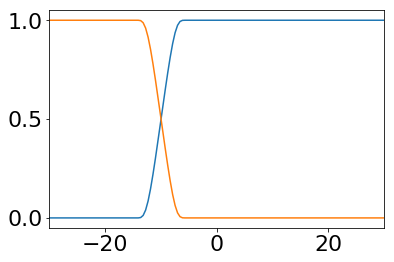

In [365]:
plt.figure()
plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.trans)
plt.plot(psi4s['q1'].times, 1. - q1_fit_fix_tdamp.trans)
plt.xlim(-30,30)

(-40, 60)

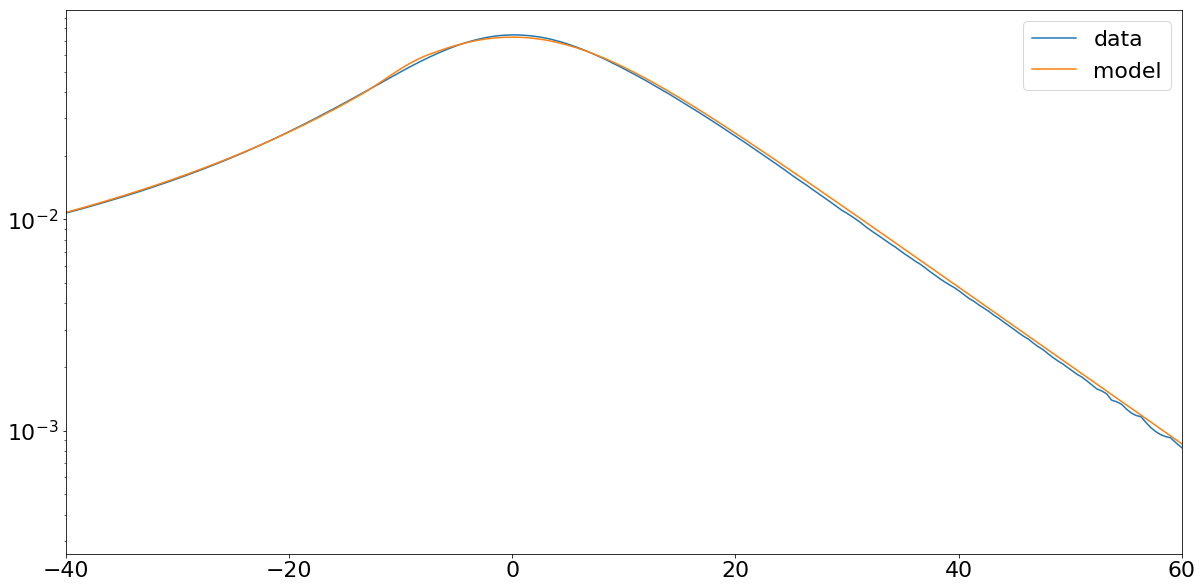

In [366]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.ramp_up, label='rampup')
# plt.plot(psi4s['q1'].times, q1_fit_fix_tdamp.bob, label='bob')

plt.plot(psi4s['q1'].times, test_full_amp, label='model')

plt.yscale('log')
plt.legend()
plt.xlim(-40,60)
# plt.ylim(0.02,0.08)

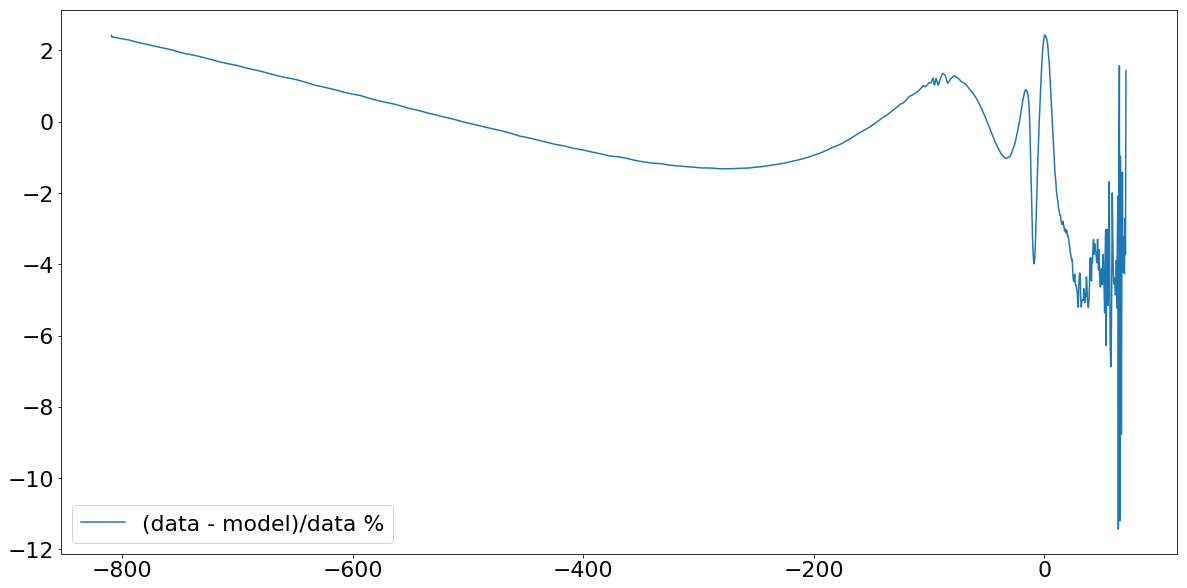

In [367]:
plt.figure(figsize=(20,10))
plt.plot(q1_fit.Psi4.times, 100*(q1_fit.Psi4.psi4lm_amp - test_full_amp)/q1_fit.Psi4.psi4lm_amp, label='(data - model)/data %')

plt.legend()
# plt.xlim(-40,40)
# plt.ylim(0.02,0.08)

In [368]:
q1_fit_fix_tdamp.compare_model_with_data()

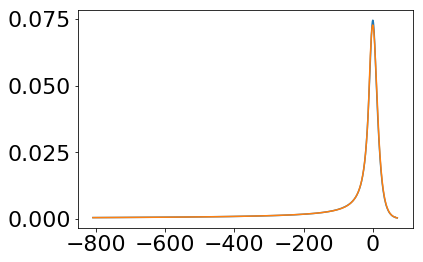

In [369]:
plt.figure()
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_data)
plt.plot(q1_fit_fix_tdamp.t_data, q1_fit_fix_tdamp.y_model)

# loop over all cases

In [388]:
fit_psi4s = {}
for k in psi4s.keys():
    print('working: {}'.format(k))
    print("\n")
    fit_psi4s.update({k:Model(psi4s[k])})
    print("fitting ramp up")
    fit_psi4s[k].fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-10)
    print("\n")
    print("fitting bob")
    fit_psi4s[k].fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
    print("\n")
    
    fit_psi4s[k].compare_model_with_data()

working: q1


fitting ramp up
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 125
    # data points      = 1795
    # variables        = 4
    chi-square         = 2.9293e-06
    reduced chi-square = 1.6356e-09
    Akaike info crit   = -36311.1591
    Bayesian info crit = -36289.1880
[[Variables]]
    tdamp:    11.70642 (fixed)
    tp:       32.0242728 +/- 0.07856440 (0.25%) (init = 20)
    lor_amp: -82.6365107 +/- 0.73411186 (0.89%) (init = 0)
    a0:      -0.37653907 +/- 7.8733e-04 (0.21%) (init = 0)
    a1:       971.253768 +/- 8.47419077 (0.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.994
    C(tp, lor_amp) = -0.993
    C(lor_amp, a0) =  0.752
    C(a0, a1)      = -0.748
    C(tp, a0)      = -0.696


fitting bob
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 68
    # variables        = 2
    chi-square         = 1.0092e

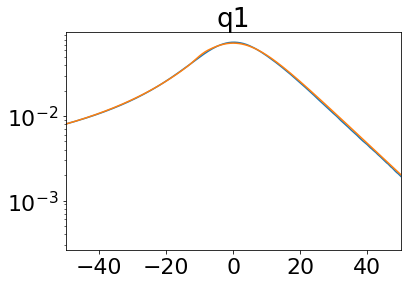

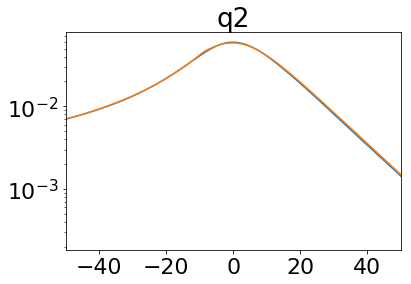

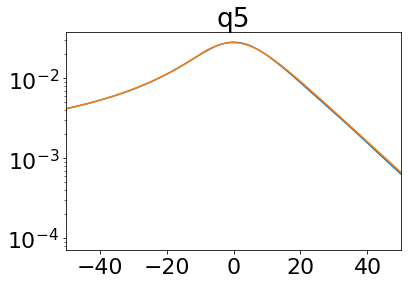

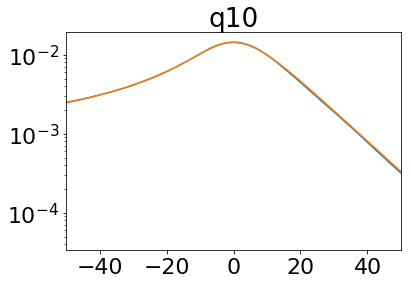

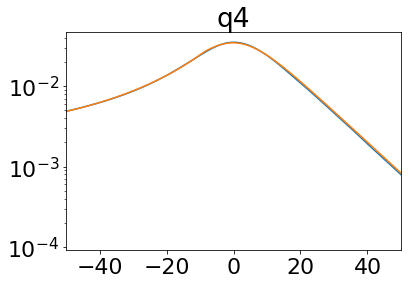

In [389]:
for k in fit_psi4s.keys():
    plt.figure()
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_data)
    plt.plot(fit_psi4s[k].t_data, fit_psi4s[k].y_model)
    plt.title(k)
    plt.xlim(-50,50)
    plt.yscale('log')
    plt.show()
    plt.close()

# vary fitting window

In [22]:
class Model_vary_window(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_amp_ramp_up(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
        
        return model
    
    def model_amp_ramp_up_to_min(self, params, t, data):
        
        t1 = params['t1']
        t2 = params['t2']

        self.model_amp_ramp_up_mask = (t > t1) & (t < t2)
        self.fit_times = t[self.model_amp_ramp_up_mask]
        self.fit_data = data[self.model_amp_ramp_up_mask]
        
        model = self.model_amp_ramp_up(params, self.fit_times)
        return model - self.fit_data
        
    def fit_amp_ramp_up(self, fix_tdamp):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
#         self.model_amp_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
#         self.fit_times = self.Psi4.times[self.model_amp_ramp_up_mask]
#         self.fit_data = self.Psi4.psi4lm_amp[self.model_amp_ramp_up_mask]

        fit_times = self.Psi4.times
        fit_data = self.Psi4.psi4lm_amp
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-100, max=200)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=2000)
        params.add('a1', value=0., min=-2000, max=20000)
        
        params.add('t1', value=-400, min=-400, max=-200, vary=False)
        params.add('t2', value=-5, min=-20, max=-4)
        
        fcn2min = self.model_amp_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(fit_times, fit_data))
        
        self.amp_ramp_up_result = minner.minimize(method='differential_evolution')

        # calculate final result
        self.amp_ramp_up_final = self.fit_data + self.amp_ramp_up_result.residual

        # write error report
        report_fit(self.amp_ramp_up_result)

In [23]:
q1_fit_fix_tdamp_vary_window = Model_vary_window(psi4s['q5'])
q1_fit_fix_tdamp_vary_window.fit_amp_ramp_up(fix_tdamp=True)

[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 52068
    # data points      = 863
    # variables        = 5
    chi-square         = 1.0725e-07
    reduced chi-square = 1.2501e-10
    Akaike info crit   = -19673.7149
    Bayesian info crit = -19649.9128
##  Warning: uncertainties could not be estimated:
[[Variables]]
    tdamp:    11.32931 (fixed)
    tp:       36.9126892 (init = 20)
    lor_amp: -54.6780084 (init = 0)
    a0:      -0.27904290 (init = 0)
    a1:       616.358187 (init = 0)
    t1:      -400 (fixed)
    t2:      -19.9938217 (init = -5)


(-300, 10)

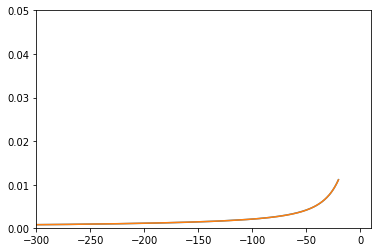

In [24]:
plt.figure()
plt.plot(q1_fit_fix_tdamp_vary_window.fit_times, q1_fit_fix_tdamp_vary_window.fit_data)
plt.plot(q1_fit_fix_tdamp_vary_window.fit_times, q1_fit_fix_tdamp_vary_window.amp_ramp_up_final)
plt.ylim(0.0001,0.05)
plt.xlim(-300, 10)

In [25]:
q1_fit_fix_tdamp_vary_window.amp_ramp_up_result.params

Parameters([('tdamp',
             <Parameter 'tdamp', value=11.32930696199893 (fixed), bounds=[-inf:inf]>),
            ('tp', <Parameter 'tp', 36.912689166282576, bounds=[-100:200]>),
            ('lor_amp',
             <Parameter 'lor_amp', -54.67800839677898, bounds=[-2000:2000]>),
            ('a0',
             <Parameter 'a0', -0.27904289835100826, bounds=[-2000:2000]>),
            ('a1', <Parameter 'a1', 616.3581868748279, bounds=[-2000:20000]>),
            ('t1', <Parameter 't1', value=-400 (fixed), bounds=[-400:-200]>),
            ('t2', <Parameter 't2', -19.993821722406054, bounds=[-20:-4]>)])

In [26]:
plt.figure()
plt.plot(q1_fit_fix_tdamp_vary_window.Psi4.times, q1_fit_fix_tdamp_vary_window.Psi4.psi4lm_amp)
plt.plot(
    q1_fit_fix_tdamp_vary_window.Psi4.times, q1_fit_fix_tdamp_vary_window.model_amp_ramp_up(
    q1_fit_fix_tdamp_vary_window.amp_ramp_up_result.params,
    q1_fit_fix_tdamp_vary_window.Psi4.times)
)
plt.ylim(0.0001,0.05)
plt.xlim(-800, 10)
plt.yscale('log')

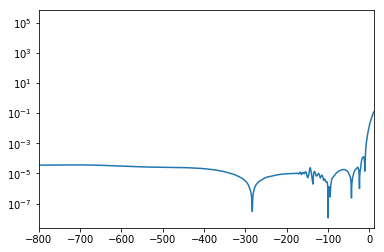

In [27]:
plt.figure()
plt.plot(
    q1_fit_fix_tdamp_vary_window.Psi4.times,
    np.abs(q1_fit_fix_tdamp_vary_window.Psi4.psi4lm_amp - q1_fit_fix_tdamp_vary_window.model_amp_ramp_up(
    q1_fit_fix_tdamp_vary_window.amp_ramp_up_result.params,
    q1_fit_fix_tdamp_vary_window.Psi4.times))
)
# plt.ylim(0.0001,0.05)
plt.xlim(-800, 10)
plt.yscale('log')

# sumit 

In [28]:
x, y = np.loadtxt("/Users/sebastian/Desktop/function_to_fit.dat", unpack=True)

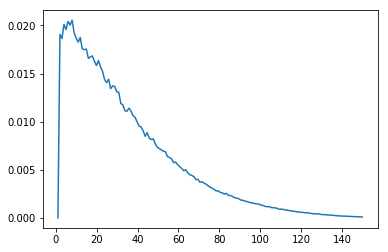

In [29]:
plt.figure()
plt.plot(x,y)

In [314]:
class Model_sumit(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
#     def func(self, params, t):
        
#         tdamp = params['tdamp']
#         tp = params['tp']
#         lor_amp = params['lor_amp']
#         a0 = params['a0']
#         a1 = params['a1']
        
#         model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
        
#         return model
    
    def func(self, params, t):
        
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
        t0 = params['t0']
        
        model = a * np.exp( (t - t0) * b ) + c / (t-t0) + d / (t-t0)**2
        
        return model



    
    
    def func_to_min(self, params, t, data):
        model = self.func(params, t)
        return model - data
        
    def fit(self, x1=0, x2=100):
        self.mask = (self.x > x1) & (self.x < x2)
        self.fit_x = self.x[self.mask]
        self.fit_y = self.y[self.mask]
        
        # create a set of Parameters
        params = Parameters()
        
#         params.add('tdamp', value=20, min=-100, max=200)
#         params.add('tp', value=-4, min=-100, max=200)
#         params.add('lor_amp', value=0., min=-2000, max=2000)
#         params.add('a0', value=0., min=-2000, max=2000, vary=True)
#         params.add('a1', value=0., min=-2000, max=2000, vary=False)

        params.add('a', value=0., min=-2000, max=2000)
        params.add('b', value=0., min=-2000, max=2000)
        params.add('c', value=0., min=-2000, max=2000)
        params.add('d', value=0., min=-2000, max=2000)
        params.add('t0', value=0., min=-2000, max=2000)
        
        fcn2min = self.func_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_x, self.fit_y))
        
        self.result = minner.minimize()

        # calculate final result
        self.final = self.fit_y + self.result.residual

        # write error report
        report_fit(self.result)
        
        

In [315]:
M1 = Model_sumit(x=x, y=y)

In [316]:
M1.fit(x1=1, x2=150)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 292
    # data points      = 149
    # variables        = 5
    chi-square         = 8.8523e-06
    reduced chi-square = 6.1474e-08
    Akaike info crit   = -2469.17888
    Bayesian info crit = -2454.15914
[[Variables]]
    a:   0.19367073 +/- 0.04944304 (25.53%) (init = 0)
    b:  -0.02822947 +/- 4.0106e-04 (1.42%) (init = 0)
    c:   0.29461463 +/- 0.16768253 (56.92%) (init = 0)
    d:  -84.0582896 +/- 38.5370789 (45.85%) (init = 0)
    t0: -43.4391958 +/- 5.62710401 (12.95%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, d)  = -0.999
    C(a, c)  =  0.998
    C(c, d)  = -0.996
    C(d, t0) =  0.995
    C(a, t0) = -0.991
    C(c, t0) = -0.984
    C(b, t0) = -0.705
    C(b, d)  = -0.637
    C(a, b)  =  0.610
    C(b, c)  =  0.572


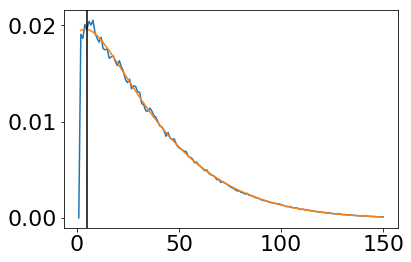

In [317]:
plt.figure()
plt.plot(x, y)
plt.plot(M1.fit_x, M1.final)
plt.axvline(5, c='k')
# plt.xscale('log')
# plt.yscale('log')